In [21]:
#Import required libraries and ML tools
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [22]:
data = pd.read_csv("cyberbullying_dataset.csv")
print("Dataset shape (rows, columns):", data.shape)

Dataset shape (rows, columns): (99990, 2)


In [23]:
data.head()

,text,label
0,@ZubearSays Any real nigga isn't letting this ...,ethnicity/race
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,not_cyberbullying
2,"the only thing i wish, i wish a nigga would",ethnicity/race
3,You saudias are not friends of Muslim idiots c...,religion
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,religion


In [24]:
print("Column names:", data.columns.tolist())
data.info()

Column names: ['text', 'label']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99990 entries, 0 to 99989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    99990 non-null  object
 1   label   99990 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [25]:
#Convert string class labels into numeric labels for model training
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping


{'ethnicity/race': 0,
 'gender/sexual': 1,
 'not_cyberbullying': 2,
 'religion': 3}

In [26]:
# Cleaning the data inside the dataset
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)          
    text = re.sub(r"@\w+", "", text)                
    text = re.sub(r"#\w+", "", text)                   
    text = re.sub(r"[^a-z\s']", " ", text)              
    text = re.sub(r"\s+", " ", text).strip() 
    return text

data["clean_text"] = data["text"].apply(clean_text)
data.head() 

,text,label,label_encoded,clean_text
0,@ZubearSays Any real nigga isn't letting this ...,ethnicity/race,0,any real nigga isn't letting this happen
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,not_cyberbullying,2,i didn't even mention mexico but the us is far...
2,"the only thing i wish, i wish a nigga would",ethnicity/race,0,the only thing i wish i wish a nigga would
3,You saudias are not friends of Muslim idiots c...,religion,3,you saudias are not friends of muslim idiots c...
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,religion,3,and yet the maga want to do just that the juda...


In [27]:
print("Column names:", data.columns.tolist())
data.info()

Column names: ['text', 'label', 'label_encoded', 'clean_text']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99990 entries, 0 to 99989
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           99990 non-null  object
 1   label          99990 non-null  object
 2   label_encoded  99990 non-null  int32 
 3   clean_text     99990 non-null  object
dtypes: int32(1), object(3)
memory usage: 2.7+ MB


In [28]:
# Feature extraction using count vectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=3000)
X = vectorizer.fit_transform(data["clean_text"])
y = data["label_encoded"]

X.shape


(99990, 3000)

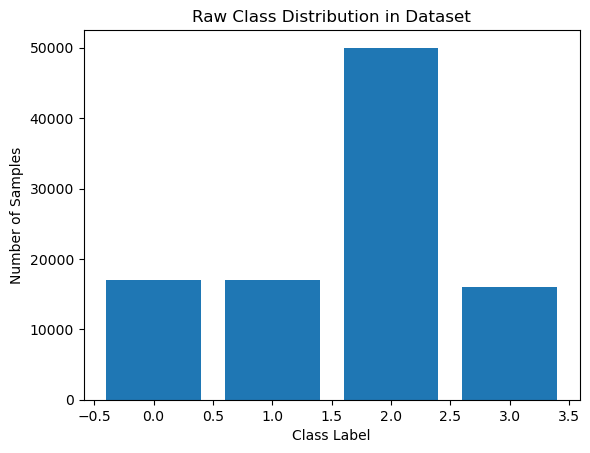

In [29]:
class_counts = data["label_encoded"].value_counts().sort_index()

plt.figure()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Raw Class Distribution in Dataset")
plt.show()

In [30]:
# Distributing training and testing data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(X_train.shape)
print(X_test.shape)

(79992, 3000)
(19998, 3000)


In [31]:
# Model 1: Multinomial Naive Bayes 
nb_model = MultinomialNB()
nb_model

MultinomialNB()

In [32]:
# Train the model on the training set
nb_model.fit(X_train, y_train)

MultinomialNB()

In [33]:
# Generate predictions for the test set
nb_predictions = nb_model.predict(X_test)
nb_predictions

array([0, 0, 2, ..., 2, 3, 2])

In [34]:
# Evaluate performance (accuracy + precision/recall/F1 per class)
nb_accuracy = classification_report(
    y_test, 
    nb_predictions,
    output_dict=True
)
nb_model_results = pd.DataFrame(nb_accuracy).transpose()
nb_model_results

,precision,recall,f1-score,support
0,0.909692,0.971765,0.939704,3400.000000
1,0.929458,0.968824,0.948733,3400.000000
2,0.989209,0.925900,0.956508,10000.000000
3,0.907279,0.982176,0.943243,3198.000000
accuracy,0.949995,0.949995,0.949995,0.949995
macro avg,0.933910,0.962166,0.947047,19998.000000
weighted avg,0.952429,0.949995,0.950208,19998.000000


In [35]:
train_accuracy_nb = nb_model.score(X_train, y_train)
test_accuracy_nb = nb_model.score(X_test, y_test)

print("Naive Bayes Training Accuracy:", train_accuracy_nb)
print("Naive Bayes Testing Accuracy:", test_accuracy_nb)

Naive Bayes Training Accuracy: 0.9527952795279528
Naive Bayes Testing Accuracy: 0.94999499949995


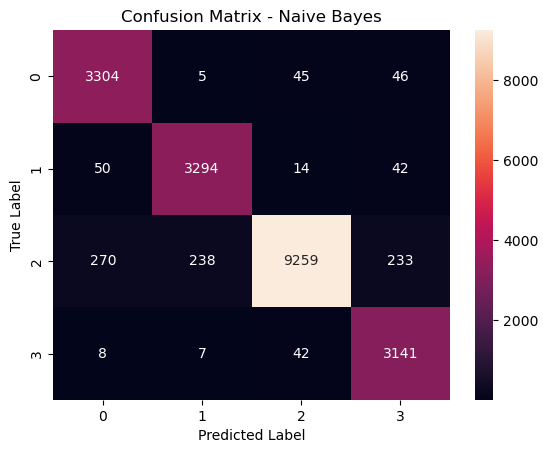

In [36]:
cm_nb = confusion_matrix(y_test, nb_predictions)

plt.figure()
sns.heatmap(cm_nb, annot=True, fmt="d")
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

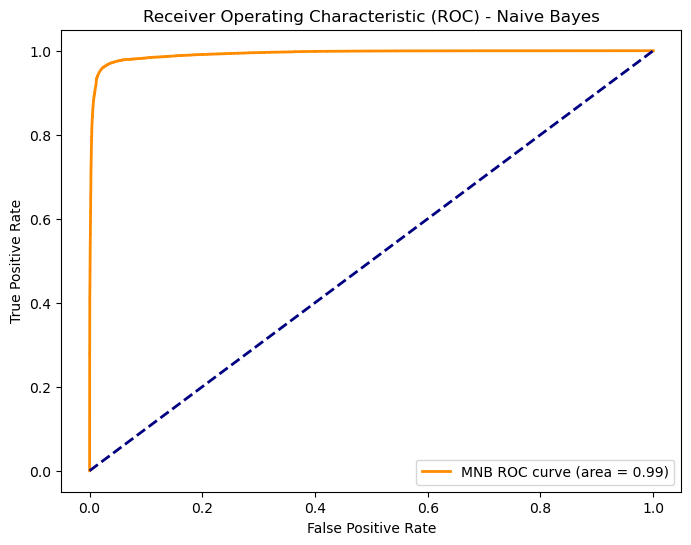

In [37]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

y_score_nb = nb_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score_nb.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'MNB ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

In [38]:
# Model 2: Logistic Regression classifier
lr_model = LogisticRegression(
    max_iter=1000,
    C=0.01,         
    penalty="l2"
)
lr_model

LogisticRegression(C=0.01, max_iter=1000)

In [39]:
# Train the model on the training set
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000)

In [40]:
# Generate predictions for the test set
lr_predictions = lr_model.predict(X_test)
lr_predictions

array([0, 0, 2, ..., 2, 3, 2])

In [41]:
# Evaluate performance (accuracy + precision/recall/F1 per class)
lr_accuracy = classification_report(
    y_test, 
    lr_predictions,
    output_dict=True
)
lr_model_results = pd.DataFrame(lr_accuracy).transpose()
lr_model_results

,precision,recall,f1-score,support
0,0.995756,0.966176,0.980743,3400.000000
1,0.984403,0.983824,0.984113,3400.000000
2,0.966361,0.999700,0.982748,10000.000000
3,0.998647,0.923077,0.959376,3198.000000
accuracy,0.979048,0.979048,0.979048,0.979048
macro avg,0.986292,0.968194,0.976745,19998.000000
weighted avg,0.979589,0.979048,0.978901,19998.000000


In [42]:
train_accuracy = lr_model.score(X_train, y_train)
test_accuracy = lr_model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9796729672967297
Testing Accuracy: 0.9790479047904791


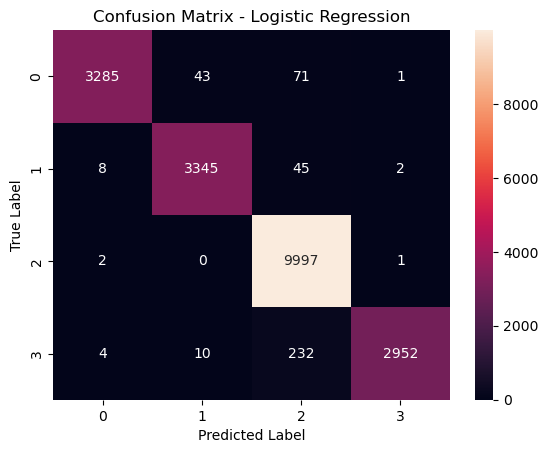

In [43]:
cm_lr = confusion_matrix(y_test, lr_predictions)

plt.figure()
sns.heatmap(cm_lr, annot=True, fmt="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

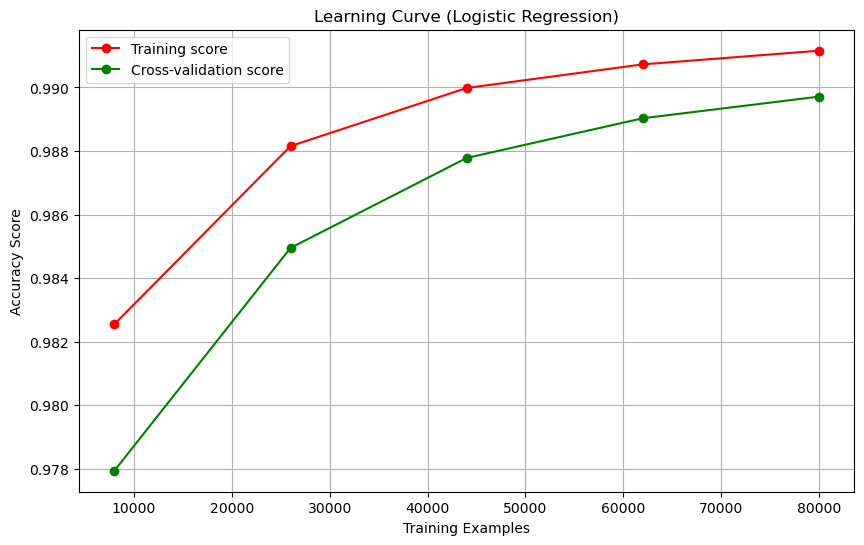

In [44]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000, C=0.1), X, y, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [45]:
# Model 3: Support Vector Machine (SVM) classifier
svm_model = SVC(
    kernel="linear",
    C=0.01
)
svm_model

SVC(C=0.01, kernel='linear')

In [46]:
# Train the model on the training set
svm_model.fit(X_train, y_train)

SVC(C=0.01, kernel='linear')

In [47]:
# Generate predictions for the test set
svm_predictions = svm_model.predict(X_test)
svm_predictions

array([0, 0, 2, ..., 2, 3, 2])

In [48]:
# Evaluate performance (accuracy + precision/recall/F1 per class)
svm_accuracy = classification_report(
    y_test, 
    svm_predictions,
    output_dict=True
)
svm_model_results = pd.DataFrame(svm_accuracy).transpose()
svm_model_results

,precision,recall,f1-score,support
0,0.994701,0.993824,0.994262,3400.000000
1,0.988850,0.991176,0.990012,3400.000000
2,0.980196,0.999800,0.989901,10000.000000
3,0.999666,0.935585,0.966564,3198.000000
accuracy,0.987049,0.987049,0.987049,0.987049
macro avg,0.990853,0.980096,0.985185,19998.000000
weighted avg,0.987247,0.987049,0.986929,19998.000000


In [49]:
train_accuracy_svm = svm_model.score(X_train, y_train)
test_accuracy_svm = svm_model.score(X_test, y_test)

print("SVM Training Accuracy:", train_accuracy_svm)
print("SVM Testing Accuracy:", test_accuracy_svm)

SVM Training Accuracy: 0.9876237623762376
SVM Testing Accuracy: 0.987048704870487


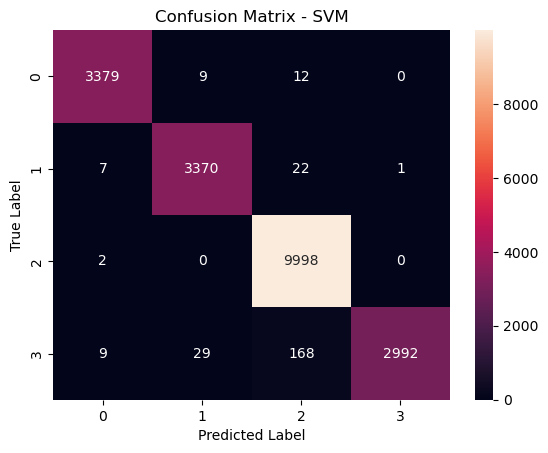

In [50]:
cm_svm = confusion_matrix(y_test, svm_predictions)

plt.figure()
sns.heatmap(cm_svm, annot=True, fmt="d")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

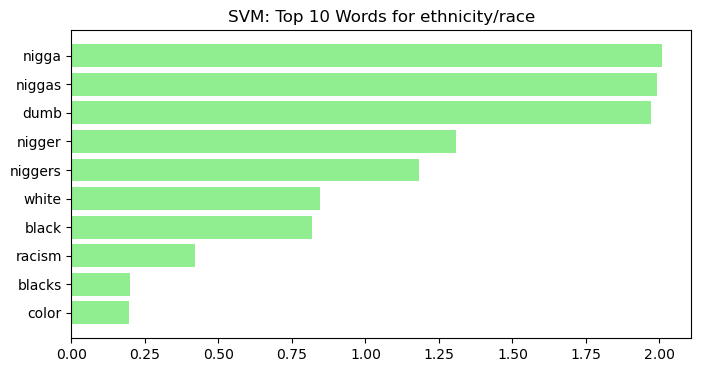

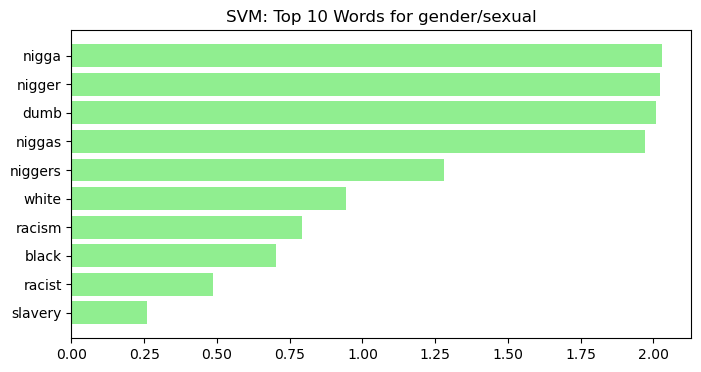

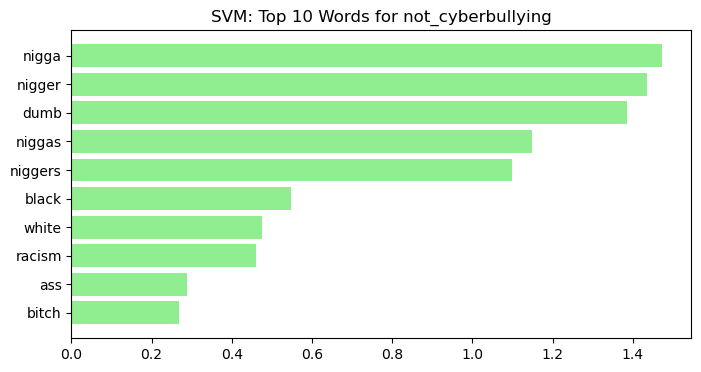

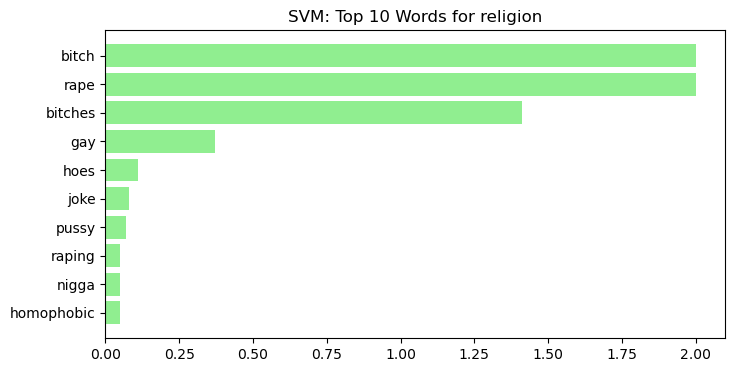

In [51]:
feature_names = vectorizer.get_feature_names_out()
for i, label in enumerate(label_encoder.classes_):
    top10_indices = svm_model.coef_[i].toarray()[0].argsort()[-10:] 
    top10_words = [feature_names[j] for j in top10_indices]
    top10_scores = svm_model.coef_[i].toarray()[0][top10_indices]

    plt.figure(figsize=(8, 4))
    plt.barh(top10_words, top10_scores, color='lightgreen')
    plt.title(f"SVM: Top 10 Words for {label}")
    plt.show()

In [52]:
# Model 4: Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=50,     
    max_depth=40,         
    min_samples_leaf=10,     
    random_state=42
)
rf_model

RandomForestClassifier(max_depth=40, min_samples_leaf=10, n_estimators=50,
                       random_state=42)

In [53]:
# Train the model on the training set
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, min_samples_leaf=10, n_estimators=50,
                       random_state=42)

In [54]:
# Generate predictions for the test set
rf_predictions = rf_model.predict(X_test)
rf_predictions

array([0, 0, 2, ..., 2, 3, 2])

In [55]:
# Evaluate performance (accuracy + precision/recall/F1 per class)
rf_accuracy = classification_report(
    y_test, 
    rf_predictions,
    output_dict=True
)
rf_model_results = pd.DataFrame(rf_accuracy).transpose()
rf_model_results

,precision,recall,f1-score,support
0,0.994012,0.976471,0.985163,3400.000000
1,0.993746,0.981471,0.987570,3400.000000
2,0.975224,0.999800,0.987359,10000.000000
3,0.997375,0.950594,0.973423,3198.000000
accuracy,0.984848,0.984848,0.984848,0.984848
macro avg,0.990089,0.977084,0.983379,19998.000000
weighted avg,0.985110,0.984848,0.984793,19998.000000


In [56]:
train_accuracy_rf = rf_model.score(X_train, y_train)
test_accuracy_rf = rf_model.score(X_test, y_test)

print("Random Forest Training Accuracy:", train_accuracy_rf)
print("Random Forest Testing Accuracy:", test_accuracy_rf)

Random Forest Training Accuracy: 0.9857235723572357
Random Forest Testing Accuracy: 0.9848484848484849


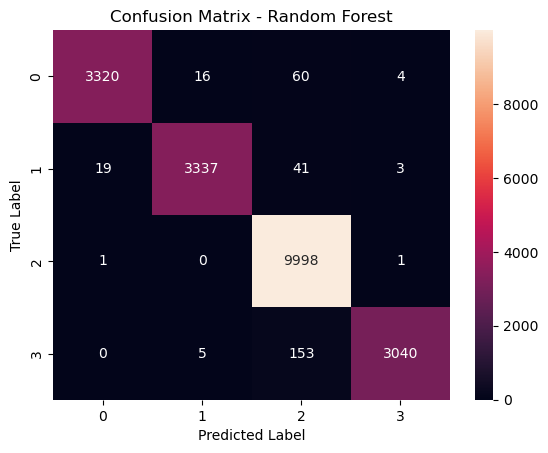

In [57]:
cm_rf = confusion_matrix(y_test, rf_predictions)

plt.figure()
sns.heatmap(cm_rf, annot=True, fmt="d")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

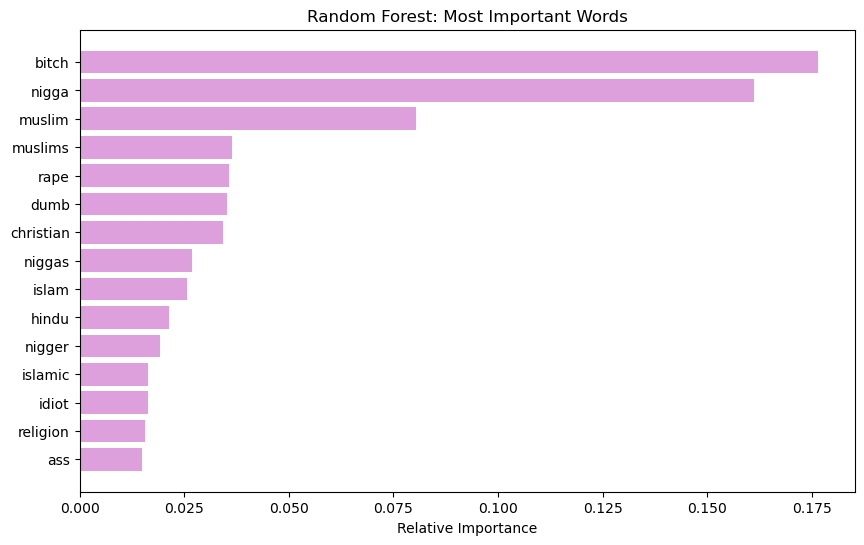

In [58]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-15:] 

plt.figure(figsize=(10, 6))
plt.title('Random Forest: Most Important Words')
plt.barh(range(len(indices)), importances[indices], color='plum', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

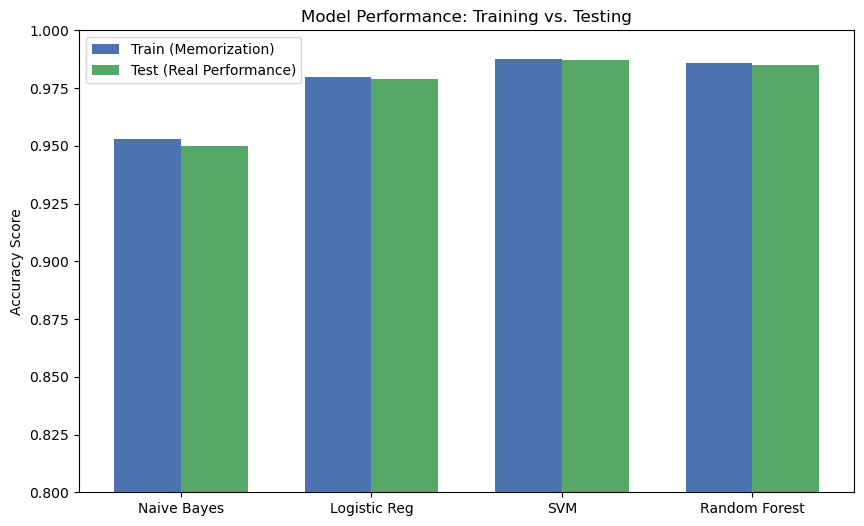

In [59]:
models = ['Naive Bayes', 'Logistic Reg', 'SVM', 'Random Forest']

train_scores = [train_accuracy_nb, train_accuracy, train_accuracy_svm, train_accuracy_rf]
test_scores = [test_accuracy_nb, test_accuracy, test_accuracy_svm, test_accuracy_rf]

x = np.arange(len(models)) 
width = 0.35              

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train (Memorization)', color='#4C72B0')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test (Real Performance)', color='#55A868')

ax.set_ylabel('Accuracy Score')
ax.set_title('Model Performance: Training vs. Testing')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.set_ylim(0.8, 1.0) 

plt.show()

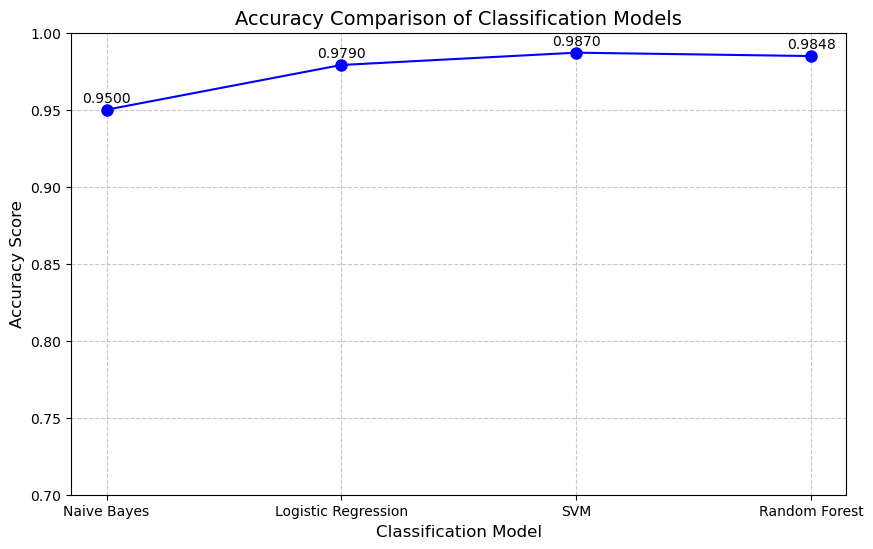

In [60]:
models = ['Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest']
accuracies = [
    test_accuracy_nb,  
    test_accuracy,      
    test_accuracy_svm,  
    test_accuracy_rf    
]

plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', linestyle='-', color='b', markersize=8)

plt.xlabel("Classification Model", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Accuracy Comparison of Classification Models", fontsize=14)

plt.ylim(0.7, 1.0) 
plt.grid(True, linestyle='--', alpha=0.7)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha='center')

plt.show()

In [61]:
# Predicting the cyberybully categories using new comment
sample_comment = ["did you really complete it all awesome"]

sample_cleaned = [clean_text(sample_comment[0])]
sample_vector = vectorizer.transform(sample_cleaned)

In [62]:
models_dict = {
    "Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "SVM": svm_model,
    "Random Forest": rf_model
}

predictions = {}

for name, model in models_dict.items():
    predictions[name] = model.predict(sample_vector)[0]

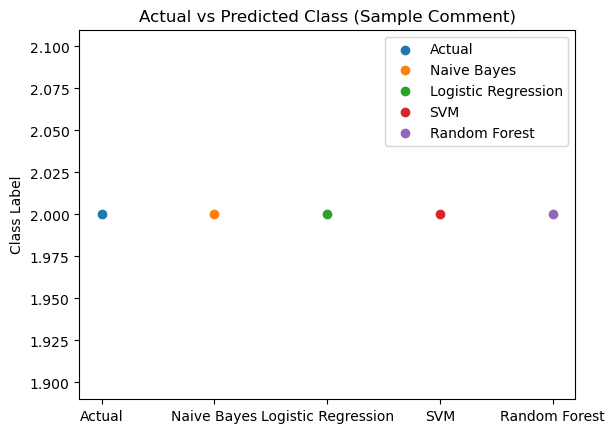

In [63]:
actual_label = 2

plt.figure()
plt.scatter("Actual", actual_label, label="Actual")
for model, pred in predictions.items():
    plt.scatter(model, pred, label=model)

plt.ylabel("Class Label")
plt.title("Actual vs Predicted Class (Sample Comment)")
plt.legend()
plt.show()